In [1]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from transformers import SwinForImageClassification
from functools import partial
import shutil

def write_to_txt(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)

def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

for dataset_path in dataset_paths:
    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the Swin model
    model = SwinForImageClassification.from_pretrained('microsoft/swin-large-patch4-window7-224').to(device)
    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((480, 640)), # Adjust size for Swin
        transforms.ToTensor(),
        normalize
    ])

    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    true_labels = []
    predicted_labels = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_swin"
    os.makedirs(target_dir, exist_ok=True)

    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)  
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0)).logits
            predicted_label = torch.argmax(logits, dim=1).item()
        
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        
        # # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label, filename)
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    results = []

    results.append(f"Precision: {precision:.4f}\n")
    results.append(f"Recall: {recall:.4f}\n")
    results.append(f"F1 Score: {f1:.4f}\n")
    results.append("\n")

    full_matrix = confusion_matrix(true_labels, predicted_labels)
    for target_class in set(true_labels):
        tp = full_matrix[target_class, target_class]
        fp = sum(full_matrix[:, target_class]) - tp
        fn = sum(full_matrix[target_class, :]) - tp
        tn = sum(sum(full_matrix)) - tp - fp - fn
        print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        results.append(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}\n")


    dataset_name = os.path.basename(dataset_path)
    model_name = "microsoft-swin"
    # Prepare the metrics filename with the model name and dataset name
    metrics_filename = f"{model_name}_{dataset_name}.txt"
    metrics_path = os.path.join(os.path.dirname(dataset_path), metrics_filename)
    with open(metrics_path, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

        for target_class in sorted(set(true_labels)):
            matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
            if matrix.size == 1:
                value = matrix[0][0]
                if target_class in predicted_labels:  # It was predicted at least once
                    tp = value
                    tn, fp, fn = 0, 0, 0
                else:  # It was never predicted
                    tn = value
                    tp, fp, fn = 0, 0, 0
            else:
                tn, fp, fn, tp = matrix.ravel() if matrix.size == 4 else (0, 0, 0, matrix[0][0])
            # Now we append the confusion matrix for each class to the file
            f.write(f"Class {target_class} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")

    print(f"Metrics saved to {metrics_path}")

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10000/10000 [05:30<00:00, 30.22it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7624
Recall: 0.7057
F1 Score: 0.7011
For class 0: TP=9, FP=3, FN=1, TN=9987
For class 1: TP=9, FP=1, FN=1, TN=9989
For class 2: TP=8, FP=2, FN=2, TN=9988
For class 3: TP=7, FP=4, FN=3, TN=9986
For class 4: TP=4, FP=1, FN=6, TN=9989
For class 5: TP=9, FP=13, FN=1, TN=9977
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=3, FP=1, FN=7, TN=9989
For class 8: TP=8, FP=6, FN=2, TN=9984
For class 9: TP=10, FP=1, FN=0, TN=9989
For class 10: TP=10, FP=7, FN=0, TN=9983
For class 11: TP=8, FP=0, FN=2, TN=9990
For class 12: TP=9, FP=0, FN=1, TN=9990
For class 13: TP=8, FP=0, FN=2, TN=9990
For class 14: TP=8, FP=0, FN=2, TN=9990
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=7, FP=0, FN=3, TN=9990
For class 17: TP=8, FP=0, FN=2, TN=9990
For class 18: TP=4, FP=0, FN=6, TN=9990
For class 19: TP=8, FP=0, FN=2, TN=9990
For class 20: TP=9, FP=1, FN=1, TN=9989
For class 21: TP=9, FP=12, FN=1, TN=9978
For class 22: TP=9, FP=0, FN=1, TN=9990
For class 23: TP=9, FP=1, FN=1, TN=

100%|██████████| 10000/10000 [05:18<00:00, 31.41it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7252
Recall: 0.6421
F1 Score: 0.6395
For class 0: TP=9, FP=2, FN=1, TN=9988
For class 1: TP=8, FP=1, FN=2, TN=9989
For class 2: TP=5, FP=2, FN=5, TN=9988
For class 3: TP=6, FP=6, FN=4, TN=9984
For class 4: TP=1, FP=0, FN=9, TN=9990
For class 5: TP=9, FP=19, FN=1, TN=9971
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=3, FP=1, FN=7, TN=9989
For class 8: TP=7, FP=6, FN=3, TN=9984
For class 9: TP=9, FP=1, FN=1, TN=9989
For class 10: TP=10, FP=7, FN=0, TN=9983
For class 11: TP=8, FP=0, FN=2, TN=9990
For class 12: TP=8, FP=0, FN=2, TN=9990
For class 13: TP=6, FP=0, FN=4, TN=9990
For class 14: TP=8, FP=0, FN=2, TN=9990
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=7, FP=0, FN=3, TN=9990
For class 17: TP=7, FP=0, FN=3, TN=9990
For class 18: TP=4, FP=0, FN=6, TN=9990
For class 19: TP=7, FP=0, FN=3, TN=9990
For class 20: TP=9, FP=1, FN=1, TN=9989
For class 21: TP=7, FP=14, FN=3, TN=9976
For class 22: TP=8, FP=0, FN=2, TN=9990
For class 23: TP=9, FP=1, FN=1, TN=9

100%|██████████| 10000/10000 [05:23<00:00, 30.95it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6833
Recall: 0.5419
F1 Score: 0.5506
For class 0: TP=9, FP=2, FN=1, TN=9988
For class 1: TP=6, FP=1, FN=4, TN=9989
For class 2: TP=3, FP=2, FN=7, TN=9988
For class 3: TP=5, FP=4, FN=5, TN=9986
For class 4: TP=1, FP=0, FN=9, TN=9990
For class 5: TP=8, FP=29, FN=2, TN=9961
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=2, FP=0, FN=8, TN=9990
For class 8: TP=6, FP=5, FN=4, TN=9985
For class 9: TP=7, FP=1, FN=3, TN=9989
For class 10: TP=9, FP=6, FN=1, TN=9984
For class 11: TP=6, FP=0, FN=4, TN=9990
For class 12: TP=8, FP=0, FN=2, TN=9990
For class 13: TP=6, FP=0, FN=4, TN=9990
For class 14: TP=8, FP=0, FN=2, TN=9990
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=5, FP=0, FN=5, TN=9990
For class 17: TP=7, FP=0, FN=3, TN=9990
For class 18: TP=4, FP=0, FN=6, TN=9990
For class 19: TP=7, FP=0, FN=3, TN=9990
For class 20: TP=6, FP=0, FN=4, TN=9990
For class 21: TP=8, FP=11, FN=2, TN=9979
For class 22: TP=7, FP=0, FN=3, TN=9990
For class 23: TP=9, FP=0, FN=1, TN=99

100%|██████████| 10000/10000 [05:31<00:00, 30.14it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7483
Recall: 0.6566
F1 Score: 0.6601
For class 0: TP=9, FP=2, FN=1, TN=9988
For class 1: TP=10, FP=3, FN=0, TN=9987
For class 2: TP=8, FP=2, FN=2, TN=9988
For class 3: TP=6, FP=1, FN=4, TN=9989
For class 4: TP=6, FP=3, FN=4, TN=9987
For class 5: TP=8, FP=11, FN=2, TN=9979
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=7, FP=2, FN=3, TN=9988
For class 8: TP=7, FP=3, FN=3, TN=9987
For class 9: TP=10, FP=10, FN=0, TN=9980
For class 10: TP=10, FP=8, FN=0, TN=9982
For class 11: TP=6, FP=0, FN=4, TN=9990
For class 12: TP=9, FP=0, FN=1, TN=9990
For class 13: TP=8, FP=0, FN=2, TN=9990
For class 14: TP=8, FP=3, FN=2, TN=9987
For class 15: TP=8, FP=0, FN=2, TN=9990
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=9, FP=0, FN=1, TN=9990
For class 18: TP=6, FP=0, FN=4, TN=9990
For class 19: TP=7, FP=0, FN=3, TN=9990
For class 20: TP=7, FP=1, FN=3, TN=9989
For class 21: TP=9, FP=8, FN=1, TN=9982
For class 22: TP=8, FP=0, FN=2, TN=9990
For class 23: TP=9, FP=0, FN=1, TN

100%|██████████| 10000/10000 [05:40<00:00, 29.41it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7075
Recall: 0.5670
F1 Score: 0.5743
For class 0: TP=9, FP=1, FN=1, TN=9989
For class 1: TP=10, FP=5, FN=0, TN=9985
For class 2: TP=8, FP=3, FN=2, TN=9987
For class 3: TP=6, FP=1, FN=4, TN=9989
For class 4: TP=5, FP=3, FN=5, TN=9987
For class 5: TP=7, FP=11, FN=3, TN=9979
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=7, FP=3, FN=3, TN=9987
For class 8: TP=7, FP=2, FN=3, TN=9988
For class 9: TP=10, FP=14, FN=0, TN=9976
For class 10: TP=10, FP=13, FN=0, TN=9977
For class 11: TP=3, FP=0, FN=7, TN=9990
For class 12: TP=9, FP=0, FN=1, TN=9990
For class 13: TP=7, FP=0, FN=3, TN=9990
For class 14: TP=8, FP=1, FN=2, TN=9989
For class 15: TP=8, FP=0, FN=2, TN=9990
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=6, FP=0, FN=4, TN=9990
For class 18: TP=4, FP=0, FN=6, TN=9990
For class 19: TP=7, FP=0, FN=3, TN=9990
For class 20: TP=7, FP=3, FN=3, TN=9987
For class 21: TP=8, FP=8, FN=2, TN=9982
For class 22: TP=8, FP=0, FN=2, TN=9990
For class 23: TP=7, FP=0, FN=3, T

100%|██████████| 10000/10000 [05:11<00:00, 32.07it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6224
Recall: 0.4013
F1 Score: 0.4156
For class 0: TP=8, FP=0, FN=2, TN=9990
For class 1: TP=9, FP=13, FN=1, TN=9977
For class 2: TP=2, FP=2, FN=8, TN=9988
For class 3: TP=4, FP=0, FN=6, TN=9990
For class 4: TP=4, FP=3, FN=6, TN=9987
For class 5: TP=3, FP=13, FN=7, TN=9977
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=7, FP=4, FN=3, TN=9986
For class 8: TP=6, FP=1, FN=4, TN=9989
For class 9: TP=9, FP=22, FN=1, TN=9968
For class 10: TP=8, FP=17, FN=2, TN=9973
For class 11: TP=3, FP=0, FN=7, TN=9990
For class 12: TP=9, FP=0, FN=1, TN=9990
For class 13: TP=3, FP=0, FN=7, TN=9990
For class 14: TP=8, FP=1, FN=2, TN=9989
For class 15: TP=6, FP=2, FN=4, TN=9988
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=6, FP=0, FN=4, TN=9990
For class 18: TP=3, FP=0, FN=7, TN=9990
For class 19: TP=4, FP=0, FN=6, TN=9990
For class 20: TP=6, FP=13, FN=4, TN=9977
For class 21: TP=6, FP=8, FN=4, TN=9982
For class 22: TP=5, FP=0, FN=5, TN=9990
For class 23: TP=3, FP=0, FN=7, TN

100%|██████████| 10000/10000 [05:11<00:00, 32.13it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7933
Recall: 0.7570
F1 Score: 0.7541
For class 0: TP=9, FP=1, FN=1, TN=9989
For class 1: TP=10, FP=1, FN=0, TN=9989
For class 2: TP=10, FP=3, FN=0, TN=9987
For class 3: TP=6, FP=2, FN=4, TN=9988
For class 4: TP=8, FP=1, FN=2, TN=9989
For class 5: TP=9, FP=10, FN=1, TN=9980
For class 6: TP=1, FP=0, FN=9, TN=9990
For class 7: TP=5, FP=2, FN=5, TN=9988
For class 8: TP=8, FP=4, FN=2, TN=9986
For class 9: TP=10, FP=1, FN=0, TN=9989
For class 10: TP=9, FP=4, FN=1, TN=9986
For class 11: TP=8, FP=1, FN=2, TN=9989
For class 12: TP=10, FP=0, FN=0, TN=9990
For class 13: TP=10, FP=0, FN=0, TN=9990
For class 14: TP=8, FP=0, FN=2, TN=9990
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=8, FP=0, FN=2, TN=9990
For class 18: TP=6, FP=0, FN=4, TN=9990
For class 19: TP=9, FP=0, FN=1, TN=9990
For class 20: TP=9, FP=1, FN=1, TN=9989
For class 21: TP=9, FP=7, FN=1, TN=9983
For class 22: TP=10, FP=0, FN=0, TN=9990
For class 23: TP=10, FP=1, FN=0, 

100%|██████████| 10000/10000 [05:07<00:00, 32.47it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7759
Recall: 0.7330
F1 Score: 0.7295
For class 0: TP=9, FP=1, FN=1, TN=9989
For class 1: TP=10, FP=2, FN=0, TN=9988
For class 2: TP=10, FP=3, FN=0, TN=9987
For class 3: TP=6, FP=2, FN=4, TN=9988
For class 4: TP=6, FP=1, FN=4, TN=9989
For class 5: TP=9, FP=13, FN=1, TN=9977
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=5, FP=1, FN=5, TN=9989
For class 8: TP=7, FP=4, FN=3, TN=9986
For class 9: TP=10, FP=1, FN=0, TN=9989
For class 10: TP=10, FP=6, FN=0, TN=9984
For class 11: TP=7, FP=0, FN=3, TN=9990
For class 12: TP=10, FP=0, FN=0, TN=9990
For class 13: TP=10, FP=0, FN=0, TN=9990
For class 14: TP=8, FP=0, FN=2, TN=9990
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=8, FP=0, FN=2, TN=9990
For class 18: TP=3, FP=0, FN=7, TN=9990
For class 19: TP=8, FP=0, FN=2, TN=9990
For class 20: TP=9, FP=2, FN=1, TN=9988
For class 21: TP=9, FP=7, FN=1, TN=9983
For class 22: TP=9, FP=0, FN=1, TN=9990
For class 23: TP=10, FP=0, FN=0,

100%|██████████| 10000/10000 [05:08<00:00, 32.43it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7417
Recall: 0.6752
F1 Score: 0.6725
For class 0: TP=9, FP=2, FN=1, TN=9988
For class 1: TP=9, FP=3, FN=1, TN=9987
For class 2: TP=10, FP=4, FN=0, TN=9986
For class 3: TP=6, FP=2, FN=4, TN=9988
For class 4: TP=6, FP=1, FN=4, TN=9989
For class 5: TP=9, FP=19, FN=1, TN=9971
For class 6: TP=0, FP=0, FN=10, TN=9990
For class 7: TP=6, FP=1, FN=4, TN=9989
For class 8: TP=6, FP=3, FN=4, TN=9987
For class 9: TP=10, FP=1, FN=0, TN=9989
For class 10: TP=10, FP=5, FN=0, TN=9985
For class 11: TP=7, FP=0, FN=3, TN=9990
For class 12: TP=10, FP=0, FN=0, TN=9990
For class 13: TP=10, FP=0, FN=0, TN=9990
For class 14: TP=8, FP=1, FN=2, TN=9989
For class 15: TP=9, FP=0, FN=1, TN=9990
For class 16: TP=8, FP=0, FN=2, TN=9990
For class 17: TP=8, FP=0, FN=2, TN=9990
For class 18: TP=3, FP=0, FN=7, TN=9990
For class 19: TP=8, FP=0, FN=2, TN=9990
For class 20: TP=8, FP=1, FN=2, TN=9989
For class 21: TP=7, FP=7, FN=3, TN=9983
For class 22: TP=9, FP=0, FN=1, TN=9990
For class 23: TP=9, FP=0, FN=1, T

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[codecarbon INFO @ 12:42:13] [setup] RAM Tracking...
[codecarbon INFO @ 12:42:13] [setup] GPU Tracking...
[codecarbon INFO @ 12:42:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:42:13] [setup] CPU Tracking...
[codecarbon WARNING @ 12:42:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:42:14] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 12:42:14] >>> Tracker's metadata:
[codecarbon INFO @ 12:42:14]   Platform system: Linux-6.2.0-36-generic-x86_64-with-glibc2.17
[codecarbon INFO @ 12:42:14]   Python version: 3.8.18
[codecarbon INFO @ 12:42:14]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 12:42:14]   Available RAM : 31.242 GB
[

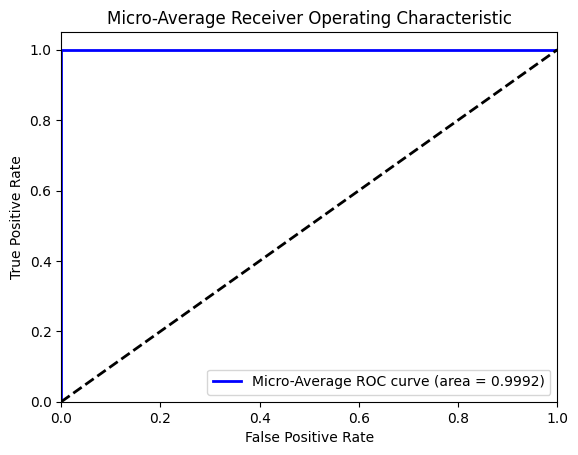

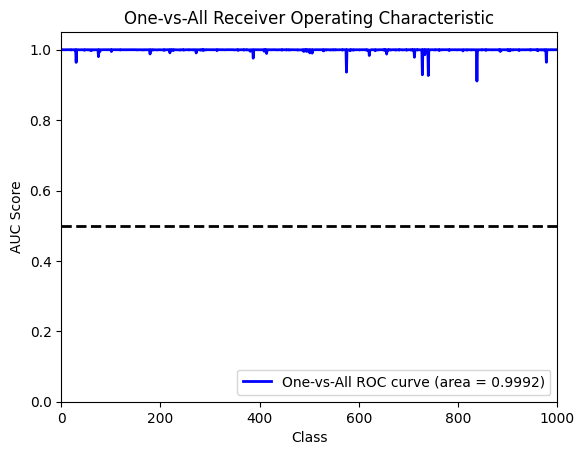

[codecarbon INFO @ 12:46:37] Energy consumed for RAM : 0.000844 kWh. RAM Power : 11.715703010559082 W
[codecarbon INFO @ 12:46:37] Energy consumed for all GPUs : 0.008782 kWh. Total GPU Power : 68.7218312366665 W
[codecarbon INFO @ 12:46:37] Energy consumed for all CPUs : 0.003424 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 12:46:37] 0.013051 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:46:37] Already started tracking


Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_swin/swin_val_images10k_metrics.txt


 10%|▉         | 992/10000 [00:22<03:24, 44.13it/s]


KeyboardInterrupt: 

In [1]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from transformers import SwinForImageClassification
from functools import partial
import shutil
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import json
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
from scipy.stats import ks_2samp

def write_to_txt(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)

def calculate_ks_statistic(distribution1, distribution2):
    ks_statistic, p_value = ks_2samp(distribution1, distribution2)
    return ks_statistic

def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]
original_dataset_probs = None

from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
for dataset_path in dataset_paths:
    tracker.start()

    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the Swin model
    model = SwinForImageClassification.from_pretrained('microsoft/swin-large-patch4-window7-224').to(device)
    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size for Swin
        transforms.ToTensor(),
        normalize
    ])

    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img
    
    predicted_probs = []
    true_labels = []
    predicted_labels = []

    target_dir = dataset_path + "_swin"
    os.makedirs(target_dir, exist_ok=True)
    num_classes = 1000

    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)  
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0)).logits
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_probs.append(probabilities)
        predicted_label = np.argmax(probabilities)
        predicted_labels.append(predicted_label)

    true_labels_binary = label_binarize(true_labels, classes=range(num_classes))
    predicted_probs = np.array(predicted_probs)

    fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), predicted_probs.ravel())
    roc_auc = auc(fpr, tpr)

    class_auc_scores = []
    for i in range(num_classes):
        true_binary = (np.array(true_labels) == i).astype(int)
        pred_probs = predicted_probs[:, i]
        fpr, tpr, _ = roc_curve(true_binary, pred_probs)
        auc_score = auc(fpr, tpr)
        class_auc_scores.append(auc_score)
    roc_auc_one_vs_rest = np.mean(class_auc_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-Average ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(target_dir, f"{os.path.basename(dataset_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.show()

    plt.figure()
    plt.plot(range(num_classes), class_auc_scores, color='blue', lw=2, label='One-vs-All ROC curve (area = {0:0.4f})'.format(roc_auc_one_vs_rest))
    plt.plot([0, num_classes], [0.5, 0.5], 'k--', lw=2)
    plt.xlim([0, num_classes])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Class')
    plt.ylabel('AUC Score')
    plt.title('One-vs-All Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(target_dir, f"{os.path.basename(dataset_path)}_one_vs_all_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.show()

    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
    cm = confusion_matrix(true_labels, predicted_labels)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp

    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    dataset_name = os.path.basename(dataset_path)
    model_name = "swin"
    metrics_filename = f"{model_name}_{dataset_name}_metrics.txt"
    metrics_path = os.path.join(target_dir, metrics_filename)
    
    if dataset_path == dataset_paths[0]:
        original_dataset_probs = [max(probs) for probs in predicted_probs]  # 选择最高的概率值
    else:
        # 对于攻击数据集
        attacked_dataset_probs = [max(probs) for probs in predicted_probs]
        ks_statistic = calculate_ks_statistic(original_dataset_probs, attacked_dataset_probs)
        print(f"K-S statistic for {os.path.basename(dataset_path)}: {ks_statistic:.5f}")

        # 将K-S值写入度量文件
        with open(metrics_path, "a") as f:
            f.write(f"K-S Statistic (vs original): {ks_statistic:.5f}\n")

    with open(metrics_path, "w") as f:
        f.write(f"Micro-Average AUC: {roc_auc:.5f}\n")
        f.write(f"One-vs-All Average AUC: {roc_auc_one_vs_rest:.5f}\n")
        f.write(f"Precision (micro-average): {precision:.5f}\n")
        f.write(f"Recall (micro-average): {recall:.5f}\n")
        f.write(f"F1 Score (micro-average): {f1_score:.5f}\n")
        f.write(f"True Positives (per class): {tp.tolist()}\n")
        f.write(f"False Positives (per class): {fp.tolist()}\n")
        f.write(f"False Negatives (per class): {fn.tolist()}\n")
        f.write(f"True Negatives (per class): {tn.tolist()}\n")

    print(f"Metrics saved to {metrics_path}")
    tracker.stop()

In [2]:
# Predict using first image in the dataset
sample_img, _, _ = dataset[0]
sample_img_tensor = transform(ensure_rgb(sample_img)).to(device)

with torch.no_grad():
    logits = model(sample_img_tensor.unsqueeze(0)).logits
print(logits)


tensor([[ 5.0104e-01, -3.6428e-01,  2.8249e-01, -5.8497e-01, -5.5468e-01,
         -4.5091e-01, -6.3339e-01, -4.8247e-01, -4.9209e-01, -5.0418e-01,
         -2.5202e-01, -7.6444e-01, -6.4445e-01, -8.4869e-01, -1.6366e-01,
         -9.7009e-01, -8.4006e-01,  5.8486e-02, -3.6983e-01, -3.7697e-01,
         -8.4172e-01, -7.4587e-01, -3.7360e-01, -1.0674e+00, -8.7907e-01,
         -7.9973e-01, -5.2128e-01, -1.0073e+00, -8.4461e-01, -1.3975e-01,
         -3.3977e-01, -8.7854e-01,  1.6982e-01, -6.6590e-01, -1.2348e-01,
         -2.4368e-01, -3.4368e-01, -5.7734e-01, -3.2035e-01, -4.6657e-01,
         -4.8395e-01, -1.6291e-01, -3.7704e-01, -7.4798e-01, -4.2434e-01,
          6.2564e-02, -2.5552e-01,  1.9844e-02, -5.7954e-01, -1.0869e+00,
         -4.4718e-01,  1.2873e-01, -8.7805e-01, -9.4121e-01, -8.8688e-01,
         -4.3054e-01, -7.0956e-01, -7.6898e-01, -7.0914e-01, -1.0875e+00,
         -2.5093e-02, -1.9637e-01, -3.1604e-02,  2.6622e-02, -2.5560e-02,
          3.5854e-01, -1.0406e+00, -6.

In [3]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from tqdm import tqdm
from transformers import SegformerForImageClassification
from functools import partial
import shutil

def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

for dataset_path in dataset_paths:
    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the Segformer model
    model = SegformerForImageClassification.from_pretrained('nvidia/mit-b0').to(device)
    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((480, 640)), # Adjust size for Segformer
        transforms.ToTensor(),
        normalize
    ])

    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    true_labels = []
    predicted_labels = []
    predicted_scores = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_mit"
    os.makedirs(target_dir, exist_ok=True)

    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)  
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0)).logits
            predicted_label = torch.argmax(logits, dim=1).item()
            predicted_score = torch.softmax(logits, dim=1).squeeze().tolist()
        
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        predicted_scores.append(predicted_score)
        
        # # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label, filename)
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    for target_class in set(true_labels):
        # Use sklearn's confusion matrix
        matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
        if matrix.size == 1:
            value = matrix[0][0]
            if target_class in predicted_labels:  # It was predicted at least once
                tp = value
                tn, fp, fn = 0, 0, 0
            else:  # It was never predicted
                tn = value
                tp, fp, fn = 0, 0, 0
        else:
            tn, fp, fn, tp = matrix.ravel()
        
        print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")



    dataset_name = os.path.basename(dataset_path)
    model_name = "nvidia-mit-b0"
    # Prepare the metrics filename with the model name and dataset name
    metrics_filename = f"{model_name}_{dataset_name}.txt"
    metrics_path = os.path.join(os.path.dirname(dataset_path), metrics_filename)
    with open(metrics_path, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

        for target_class in sorted(set(true_labels)):
            matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
            if matrix.size == 1:
                value = matrix[0][0]
                if target_class in predicted_labels:  # It was predicted at least once
                    tp = value
                    tn, fp, fn = 0, 0, 0
                else:  # It was never predicted
                    tn = value
                    tp, fp, fn = 0, 0, 0
            else:
                tn, fp, fn, tp = matrix.ravel() if matrix.size == 4 else (0, 0, 0, matrix[0][0])
            # Now we append the confusion matrix for each class to the file
            f.write(f"Class {target_class} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")

    print(f"Metrics saved to {metrics_path}")

100%|██████████| 10000/10000 [01:42<00:00, 97.36it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5007
Recall: 0.3665
F1 Score: 0.3623
For class 0: TP=6, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=4, FP=0, FN=0, TN=0
For class 4: TP=3, FP=0, FN=0, TN=0
For class 5: TP=7, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=4, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=7, FP=0, FN=0, TN=0
For class 11: TP=7, FP=0, FN=0, TN=0
For class 12: TP=9, FP=0, FN=0, TN=0
For class 13: TP=4, FP=0, FN=0, TN=0
For class 14: TP=9, FP=0, FN=0, TN=0
For class 15: TP=6, FP=0, FN=0, TN=0
For class 16: TP=3, FP=0, FN=0, TN=0
For class 17: TP=6, FP=0, FN=0, TN=0
For class 18: TP=3, FP=0, FN=0, TN=0
For class 19: TP=3, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=7, FP=0, FN=0, TN=0
For class 23: TP=1, FP=0, FN=0, TN=0
For class 24: TP=8, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:44<00:00, 95.64it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.3948
Recall: 0.2540
F1 Score: 0.2556
For class 0: TP=3, FP=0, FN=0, TN=0
For class 1: TP=6, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=4, FP=0, FN=0, TN=0
For class 4: TP=0, FP=0, FN=0, TN=0
For class 5: TP=3, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=3, FP=0, FN=0, TN=0
For class 9: TP=8, FP=0, FN=0, TN=0
For class 10: TP=4, FP=0, FN=0, TN=0
For class 11: TP=8, FP=0, FN=0, TN=0
For class 12: TP=8, FP=0, FN=0, TN=0
For class 13: TP=4, FP=0, FN=0, TN=0
For class 14: TP=9, FP=0, FN=0, TN=0
For class 15: TP=4, FP=0, FN=0, TN=0
For class 16: TP=1, FP=0, FN=0, TN=0
For class 17: TP=6, FP=0, FN=0, TN=0
For class 18: TP=3, FP=0, FN=0, TN=0
For class 19: TP=1, FP=0, FN=0, TN=0
For class 20: TP=4, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=5, FP=0, FN=0, TN=0
For class 23: TP=1, FP=0, FN=0, TN=0
For class 24: TP=5, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:43<00:00, 96.84it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.2506
Recall: 0.1188
F1 Score: 0.1240
For class 0: TP=0, FP=0, FN=0, TN=0
For class 1: TP=2, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=0, FP=0, FN=0, TN=0
For class 4: TP=0, FP=0, FN=0, TN=0
For class 5: TP=2, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=2, FP=0, FN=0, TN=0
For class 9: TP=3, FP=0, FN=0, TN=0
For class 10: TP=2, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=4, FP=0, FN=0, TN=0
For class 13: TP=1, FP=0, FN=0, TN=0
For class 14: TP=7, FP=0, FN=0, TN=0
For class 15: TP=1, FP=0, FN=0, TN=0
For class 16: TP=1, FP=0, FN=0, TN=0
For class 17: TP=5, FP=0, FN=0, TN=0
For class 18: TP=1, FP=0, FN=0, TN=0
For class 19: TP=0, FP=0, FN=0, TN=0
For class 20: TP=1, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=1, FP=0, FN=0, TN=0
For class 23: TP=2, FP=0, FN=0, TN=0
For class 24: TP=1, FP=0, FN=0, TN=0
For class 25: TP=7, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:40<00:00, 99.33it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.3075
Recall: 0.1745
F1 Score: 0.1628
For class 0: TP=1, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=0, FP=0, FN=0, TN=0
For class 4: TP=2, FP=0, FN=0, TN=0
For class 5: TP=3, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=1, FP=0, FN=0, TN=0
For class 8: TP=0, FP=0, FN=0, TN=0
For class 9: TP=1, FP=0, FN=0, TN=0
For class 10: TP=3, FP=0, FN=0, TN=0
For class 11: TP=3, FP=0, FN=0, TN=0
For class 12: TP=3, FP=0, FN=0, TN=0
For class 13: TP=0, FP=0, FN=0, TN=0
For class 14: TP=4, FP=0, FN=0, TN=0
For class 15: TP=1, FP=0, FN=0, TN=0
For class 16: TP=0, FP=0, FN=0, TN=0
For class 17: TP=0, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=0, FP=0, FN=0, TN=0
For class 20: TP=1, FP=0, FN=0, TN=0
For class 21: TP=5, FP=0, FN=0, TN=0
For class 22: TP=2, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=0, FP=0, FN=0, TN=0
For class 25: TP=5, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:38<00:00, 101.26it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1688
Recall: 0.0996
F1 Score: 0.0839
For class 0: TP=0, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=0, FP=0, FN=0, TN=0
For class 4: TP=2, FP=0, FN=0, TN=0
For class 5: TP=2, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=0, FP=0, FN=0, TN=0
For class 8: TP=0, FP=0, FN=0, TN=0
For class 9: TP=1, FP=0, FN=0, TN=0
For class 10: TP=2, FP=0, FN=0, TN=0
For class 11: TP=3, FP=0, FN=0, TN=0
For class 12: TP=0, FP=0, FN=0, TN=0
For class 13: TP=0, FP=0, FN=0, TN=0
For class 14: TP=0, FP=0, FN=0, TN=0
For class 15: TP=0, FP=0, FN=0, TN=0
For class 16: TP=0, FP=0, FN=0, TN=0
For class 17: TP=0, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=0, FP=0, FN=0, TN=0
For class 20: TP=0, FP=0, FN=0, TN=0
For class 21: TP=2, FP=0, FN=0, TN=0
For class 22: TP=1, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=0, FP=0, FN=0, TN=0
For class 25: TP=3, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:41<00:00, 98.93it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0593
Recall: 0.0384
F1 Score: 0.0264
For class 0: TP=0, FP=0, FN=0, TN=0
For class 1: TP=4, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=0, FP=0, FN=0, TN=0
For class 4: TP=1, FP=0, FN=0, TN=0
For class 5: TP=0, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=0, FP=0, FN=0, TN=0
For class 8: TP=0, FP=0, FN=0, TN=0
For class 9: TP=0, FP=0, FN=0, TN=0
For class 10: TP=0, FP=0, FN=0, TN=0
For class 11: TP=0, FP=0, FN=0, TN=0
For class 12: TP=0, FP=0, FN=0, TN=0
For class 13: TP=0, FP=0, FN=0, TN=0
For class 14: TP=0, FP=0, FN=0, TN=0
For class 15: TP=0, FP=0, FN=0, TN=0
For class 16: TP=0, FP=0, FN=0, TN=0
For class 17: TP=0, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=0, FP=0, FN=0, TN=0
For class 20: TP=0, FP=0, FN=0, TN=0
For class 21: TP=0, FP=0, FN=0, TN=0
For class 22: TP=0, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=0, FP=0, FN=0, TN=0
For class 25: TP=1, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:43<00:00, 96.52it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.4681
Recall: 0.2909
F1 Score: 0.2885
For class 0: TP=7, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=1, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=3, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=4, FP=0, FN=0, TN=0
For class 8: TP=2, FP=0, FN=0, TN=0
For class 9: TP=4, FP=0, FN=0, TN=0
For class 10: TP=5, FP=0, FN=0, TN=0
For class 11: TP=7, FP=0, FN=0, TN=0
For class 12: TP=4, FP=0, FN=0, TN=0
For class 13: TP=1, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=2, FP=0, FN=0, TN=0
For class 16: TP=2, FP=0, FN=0, TN=0
For class 17: TP=5, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=4, FP=0, FN=0, TN=0
For class 20: TP=4, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=5, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=3, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:42<00:00, 97.72it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.3462
Recall: 0.2138
F1 Score: 0.2039
For class 0: TP=5, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=1, FP=0, FN=0, TN=0
For class 3: TP=4, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=2, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=3, FP=0, FN=0, TN=0
For class 8: TP=0, FP=0, FN=0, TN=0
For class 9: TP=2, FP=0, FN=0, TN=0
For class 10: TP=5, FP=0, FN=0, TN=0
For class 11: TP=3, FP=0, FN=0, TN=0
For class 12: TP=2, FP=0, FN=0, TN=0
For class 13: TP=0, FP=0, FN=0, TN=0
For class 14: TP=7, FP=0, FN=0, TN=0
For class 15: TP=1, FP=0, FN=0, TN=0
For class 16: TP=0, FP=0, FN=0, TN=0
For class 17: TP=5, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=1, FP=0, FN=0, TN=0
For class 20: TP=0, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=4, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=0, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN=

100%|██████████| 10000/10000 [01:38<00:00, 101.94it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1927
Recall: 0.1130
F1 Score: 0.1013
For class 0: TP=0, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=0, FP=0, FN=0, TN=0
For class 3: TP=2, FP=0, FN=0, TN=0
For class 4: TP=1, FP=0, FN=0, TN=0
For class 5: TP=0, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=0, FP=0, FN=0, TN=0
For class 8: TP=0, FP=0, FN=0, TN=0
For class 9: TP=1, FP=0, FN=0, TN=0
For class 10: TP=2, FP=0, FN=0, TN=0
For class 11: TP=1, FP=0, FN=0, TN=0
For class 12: TP=0, FP=0, FN=0, TN=0
For class 13: TP=0, FP=0, FN=0, TN=0
For class 14: TP=7, FP=0, FN=0, TN=0
For class 15: TP=0, FP=0, FN=0, TN=0
For class 16: TP=0, FP=0, FN=0, TN=0
For class 17: TP=0, FP=0, FN=0, TN=0
For class 18: TP=0, FP=0, FN=0, TN=0
For class 19: TP=0, FP=0, FN=0, TN=0
For class 20: TP=0, FP=0, FN=0, TN=0
For class 21: TP=5, FP=0, FN=0, TN=0
For class 22: TP=0, FP=0, FN=0, TN=0
For class 23: TP=0, FP=0, FN=0, TN=0
For class 24: TP=0, FP=0, FN=0, TN=0
For class 25: TP=4, FP=0, FN=0, TN=

In [4]:
import os
from PIL import Image
import json
from torchvision.models import resnet50
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import shutil  

# Function to load images
def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

for dataset_path in dataset_paths:
    
    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    # Determine device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA!")
    else:
        device = torch.device("cpu")
        print("Using CPU!")

    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the model
    model = resnet50(pretrained=True).to(device)
    model.eval()
    model_name = model.__class__.__name__



    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])


    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    true_labels = []
    predicted_labels = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_" + model_name
    os.makedirs(target_dir, exist_ok=True)

    for img, label, filename in tqdm(dataset):
        img = img.resize((224, 224))  # Resize to match ResNet's expected input size
        img = ensure_rgb(img)  # Ensure the image has 3 channels
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0))
            predicted_label = torch.argmax(logits, dim=1).item()
        
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label, filename)
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file



    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


    for target_class in set(true_labels):
        # Use sklearn's confusion matrix
        matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
        if matrix.size == 1:
            value = matrix[0][0]
            if target_class in predicted_labels:  # It was predicted at least once
                tp = value
                tn, fp, fn = 0, 0, 0
            else:  # It was never predicted
                tn = value
                tp, fp, fn = 0, 0, 0
        else:
            tn, fp, fn, tp = matrix.ravel()
        
        print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")


    dataset_name = os.path.basename(dataset_path)

    # Prepare the metrics filename with the model name and dataset name
    metrics_filename = f"{model_name}_{dataset_name}.txt"
    metrics_path = os.path.join(os.path.dirname(dataset_path), metrics_filename)
    with open(metrics_path, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

        for target_class in sorted(set(true_labels)):
            matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
            if matrix.size == 1:
                value = matrix[0][0]
                if target_class in predicted_labels:  # It was predicted at least once
                    tp = value
                    tn, fp, fn = 0, 0, 0
                else:  # It was never predicted
                    tn = value
                    tp, fp, fn = 0, 0, 0
            else:
                tn, fp, fn, tp = matrix.ravel() if matrix.size == 4 else (0, 0, 0, matrix[0][0])
            # Now we append the confusion matrix for each class to the file
            f.write(f"Class {target_class} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")

    print(f"Metrics saved to {metrics_path}")

Using CUDA!


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:57<00:00, 174.41it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.6398
Recall: 0.5912
F1 Score: 0.5868
For class 0: TP=8, FP=0, FN=0, TN=0
For class 1: TP=3, FP=0, FN=0, TN=0
For class 2: TP=8, FP=0, FN=0, TN=0
For class 3: TP=4, FP=0, FN=0, TN=0
For class 4: TP=7, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=5, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=8, FP=0, FN=0, TN=0
For class 9: TP=7, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=9, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=9, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=9, FP=0, FN=0, TN=0
For class 18: TP=7, FP=0, FN=0, TN=0
For class 19: TP=6, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=4, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, TN=0
For class 25: TP=9, FP=0, FN=0,

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:00<00:00, 165.07it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.5598
Recall: 0.4818
F1 Score: 0.4786
For class 0: TP=6, FP=0, FN=0, TN=0
For class 1: TP=3, FP=0, FN=0, TN=0
For class 2: TP=8, FP=0, FN=0, TN=0
For class 3: TP=3, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=6, FP=0, FN=0, TN=0
For class 6: TP=5, FP=0, FN=0, TN=0
For class 7: TP=4, FP=0, FN=0, TN=0
For class 8: TP=5, FP=0, FN=0, TN=0
For class 9: TP=7, FP=0, FN=0, TN=0
For class 10: TP=7, FP=0, FN=0, TN=0
For class 11: TP=5, FP=0, FN=0, TN=0
For class 12: TP=9, FP=0, FN=0, TN=0
For class 13: TP=8, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=8, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=7, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=6, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=5, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=8, FP=0, FN=0, TN=0
For class 24: TP=8, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:59<00:00, 168.02it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.4321
Recall: 0.3097
F1 Score: 0.3084
For class 0: TP=5, FP=0, FN=0, TN=0
For class 1: TP=3, FP=0, FN=0, TN=0
For class 2: TP=5, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=5, FP=0, FN=0, TN=0
For class 6: TP=5, FP=0, FN=0, TN=0
For class 7: TP=4, FP=0, FN=0, TN=0
For class 8: TP=4, FP=0, FN=0, TN=0
For class 9: TP=6, FP=0, FN=0, TN=0
For class 10: TP=3, FP=0, FN=0, TN=0
For class 11: TP=2, FP=0, FN=0, TN=0
For class 12: TP=3, FP=0, FN=0, TN=0
For class 13: TP=6, FP=0, FN=0, TN=0
For class 14: TP=7, FP=0, FN=0, TN=0
For class 15: TP=4, FP=0, FN=0, TN=0
For class 16: TP=3, FP=0, FN=0, TN=0
For class 17: TP=3, FP=0, FN=0, TN=0
For class 18: TP=6, FP=0, FN=0, TN=0
For class 19: TP=2, FP=0, FN=0, TN=0
For class 20: TP=5, FP=0, FN=0, TN=0
For class 21: TP=3, FP=0, FN=0, TN=0
For class 22: TP=2, FP=0, FN=0, TN=0
For class 23: TP=7, FP=0, FN=0, TN=0
For class 24: TP=6, FP=0, FN=0, TN=0
For class 25: TP=6, FP=0, FN=0, TN=

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:52<00:00, 189.69it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.6420
Recall: 0.5892
F1 Score: 0.5845
For class 0: TP=7, FP=0, FN=0, TN=0
For class 1: TP=7, FP=0, FN=0, TN=0
For class 2: TP=8, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=6, FP=0, FN=0, TN=0
For class 5: TP=7, FP=0, FN=0, TN=0
For class 6: TP=1, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=7, FP=0, FN=0, TN=0
For class 9: TP=8, FP=0, FN=0, TN=0
For class 10: TP=10, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=6, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=8, FP=0, FN=0, TN=0
For class 16: TP=6, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=5, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=9, FP=0, FN=0, TN=0
For class 23: TP=5, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, TN=0
For class 25: TP=6, FP=0, FN=0, 

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:56<00:00, 176.15it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.5756
Recall: 0.5133
F1 Score: 0.5071
For class 0: TP=6, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=7, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=3, FP=0, FN=0, TN=0
For class 5: TP=6, FP=0, FN=0, TN=0
For class 6: TP=1, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=6, FP=0, FN=0, TN=0
For class 9: TP=7, FP=0, FN=0, TN=0
For class 10: TP=8, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=9, FP=0, FN=0, TN=0
For class 13: TP=4, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=7, FP=0, FN=0, TN=0
For class 16: TP=5, FP=0, FN=0, TN=0
For class 17: TP=8, FP=0, FN=0, TN=0
For class 18: TP=4, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=4, FP=0, FN=0, TN=0
For class 22: TP=8, FP=0, FN=0, TN=0
For class 23: TP=4, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, TN=0
For class 25: TP=5, FP=0, FN=0, TN=

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:52<00:00, 190.15it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.4594
Recall: 0.3727
F1 Score: 0.3668
For class 0: TP=6, FP=0, FN=0, TN=0
For class 1: TP=7, FP=0, FN=0, TN=0
For class 2: TP=4, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=2, FP=0, FN=0, TN=0
For class 5: TP=5, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=4, FP=0, FN=0, TN=0
For class 8: TP=5, FP=0, FN=0, TN=0
For class 9: TP=7, FP=0, FN=0, TN=0
For class 10: TP=4, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=8, FP=0, FN=0, TN=0
For class 13: TP=4, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=4, FP=0, FN=0, TN=0
For class 16: TP=4, FP=0, FN=0, TN=0
For class 17: TP=5, FP=0, FN=0, TN=0
For class 18: TP=4, FP=0, FN=0, TN=0
For class 19: TP=5, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=5, FP=0, FN=0, TN=0
For class 22: TP=5, FP=0, FN=0, TN=0
For class 23: TP=3, FP=0, FN=0, TN=0
For class 24: TP=4, FP=0, FN=0, TN=0
For class 25: TP=4, FP=0, FN=0, TN=

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:57<00:00, 172.93it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.6944
Recall: 0.6341
F1 Score: 0.6320
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=7, FP=0, FN=0, TN=0
For class 2: TP=8, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=3, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=3, FP=0, FN=0, TN=0
For class 7: TP=7, FP=0, FN=0, TN=0
For class 8: TP=7, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=5, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=7, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=5, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=9, FP=0, FN=0, TN=0
For class 23: TP=9, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, T

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:56<00:00, 178.14it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.6869
Recall: 0.6356
F1 Score: 0.6320
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=7, FP=0, FN=0, TN=0
For class 2: TP=9, FP=0, FN=0, TN=0
For class 3: TP=6, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=2, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=7, FP=0, FN=0, TN=0
For class 9: TP=7, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=5, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=8, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=5, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=8, FP=0, FN=0, TN=0
For class 22: TP=8, FP=0, FN=0, TN=0
For class 23: TP=9, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, T

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:57<00:00, 173.27it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision: 0.5837
Recall: 0.4593
F1 Score: 0.4610
For class 0: TP=7, FP=0, FN=0, TN=0
For class 1: TP=5, FP=0, FN=0, TN=0
For class 2: TP=5, FP=0, FN=0, TN=0
For class 3: TP=6, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=0, FP=0, FN=0, TN=0
For class 7: TP=4, FP=0, FN=0, TN=0
For class 8: TP=4, FP=0, FN=0, TN=0
For class 9: TP=6, FP=0, FN=0, TN=0
For class 10: TP=5, FP=0, FN=0, TN=0
For class 11: TP=1, FP=0, FN=0, TN=0
For class 12: TP=7, FP=0, FN=0, TN=0
For class 13: TP=5, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=5, FP=0, FN=0, TN=0
For class 16: TP=6, FP=0, FN=0, TN=0
For class 17: TP=6, FP=0, FN=0, TN=0
For class 18: TP=4, FP=0, FN=0, TN=0
For class 19: TP=3, FP=0, FN=0, TN=0
For class 20: TP=3, FP=0, FN=0, TN=0
For class 21: TP=5, FP=0, FN=0, TN=0
For class 22: TP=7, FP=0, FN=0, TN=0
For class 23: TP=5, FP=0, FN=0, TN=0
For class 24: TP=8, FP=0, FN=0, TN=0
For class 25: TP=8, FP=0, FN=0, TN=